# Data Preprocessing & Feature Engineering:
Now that we've wrangled our data and have done some exploratory analysis, let's move onto the feature engineering step.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
#Importing the dataframe we saved from our previous "Data Wrangling and Exploratory Data Analysis" Notebook
df = pd.read_csv('WnvDataframe',parse_dates = ['Date'])

# Feature 1: Creating Days of the Week

In [3]:
daysofweek = []
for date in df['Date'].dt.dayofweek:
    if date == 0:
        daysofweek.append('Monday')
    elif date == 1:
        daysofweek.append('Tuesday')
    elif date == 2:
        daysofweek.append('Wednesday')
    elif date == 3:
        daysofweek.append('Thursday')
    elif date == 4:
        daysofweek.append('Friday')
    elif date == 5:
        daysofweek.append('Saturday')
    else:
        daysofweek.append('Sunday')
df['DayOfWeek'] = daysofweek
df2 = pd.get_dummies(df, columns=['DayOfWeek'],prefix='',prefix_sep='')

In [4]:
df.groupby('DayOfWeek').sum()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,...,GR,HZ,MIFG,RA,SN,SQ,TS,TSRA,VCFG,VCTS
DayOfWeek,,,,,,,,,,,,,,,,,,,,,
Friday,140719,157547.1691,-330152.5122,30183,40740,135,299186.0,234001.0,267550.0,775.0,...,0,288,0,1609,0,0,523,688,0,0
Monday,42747,55040.5721,-115356.2525,10389,16469,16,113040.0,86912.0,100182.0,7893.0,...,0,178,0,254,0,0,0,317,0,0
Thursday,91494,107775.2096,-225906.4633,20199,34710,215,207314.5,159131.0,183833.0,5218.0,...,0,760,0,734,0,0,233,374,0,121
Tuesday,38591,44193.1018,-92601.9271,8197,11514,68,89049.0,68199.0,78894.0,5961.0,...,0,281,0,360,0,0,23,93,0,254
Wednesday,61385,75026.9388,-157358.0846,13184,31606,117,152031.5,120434.5,136715.0,8942.0,...,0,773,0,728,0,0,544,637,0,129


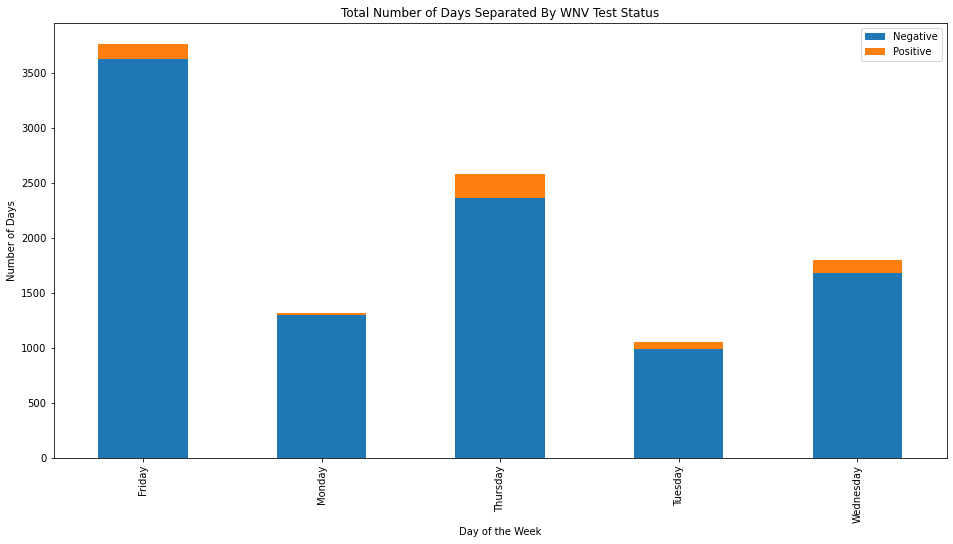

In [5]:
df['Counter'] = 1
df_dayofweek = df.groupby(['DayOfWeek','WnvPresent']).sum()
plt.rcParams["figure.figsize"] = (16,8)
df_dayofweek.Counter.unstack().plot.bar(stacked=True)
plt.title('Total Number of Days Separated By WNV Test Status')
plt.legend(labels=['Negative','Positive'])
plt.ylabel('Number of Days')
plt.xlabel('Day of the Week')
plt.show();

# Feature 2: Days Since Previous Weather Condition

In [46]:
df2['TimeSinceLastHZ'] = df2['Date'] - df2.groupby(df2['HZ'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastHZ'] = df2['Date'] - df2.groupby(df2['HZ'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastHZ'] = df2['Date'] - df2.groupby(df2['HZ'].eq(1).cumsum())['Date'].transform('min')
# There are ~two year gaps between the data - we want to mark off the start of a new year of data with "N/A" instead of 600+ days
for i in range(len(df2['TimeSinceLastHZ'])):
    if df2['TimeSinceLastHZ'][i] > pd.Timedelta(days=365):
        df2['TimeSinceLastHZ'][i] = np.nan
    else:
        pass
    try:
        df2['TimeSinceLastHZ'][i] = float(df2['TimeSinceLastHZ'][i].days) #Convert timedelta into float data type so it computes better with the other features.
    except:
        pass
df2['TimeSinceLastHZ'] = pd.to_numeric(df2['TimeSinceLastHZ'],errors='coerce')

C:\Users\jhua\AppData\Local\Temp\ipykernel_14008\2969683086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TimeSinceLastHZ'][i] = float(df2['TimeSinceLastHZ'][i].days) #Convert timedelta into float data type so it computes better with the other features.
C:\Users\jhua\AppData\Local\Temp\ipykernel_14008\2969683086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['TimeSinceLastHZ'][i] = float(df2['TimeSinceLastHZ'][i].days) #Convert timedelta into float data type so it computes better with the other features.
C:\Users\jhua\AppData\Local\Temp\ipykernel_14008\2969683086.py:5: SettingWithCopyWarning: 
A val

In [47]:
df2.corr()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,...,TS,TSRA,VCFG,VCTS,Friday,Monday,Thursday,Tuesday,Wednesday,TimeSinceLastHZ
Block,1.000000,0.091110,-0.090339,0.222134,-0.172388,0.004877,-0.001626,-0.012585,-0.006533,-0.002674,...,0.016904,-0.021261,NaN,0.029122,0.052119,-0.049431,-0.003980,0.011767,-0.027791,0.015051
Latitude,0.091110,1.000000,-0.701833,0.444019,-0.184790,0.028698,-0.065804,-0.097396,-0.084929,-0.084895,...,-0.016252,-0.011607,NaN,0.049668,0.100589,0.049692,-0.014838,0.024879,-0.174750,0.090893
Longitude,-0.090339,-0.701833,1.000000,-0.456749,0.036611,-0.060349,0.081052,0.101176,0.095625,0.105599,...,0.035065,0.015518,NaN,-0.019089,-0.102965,-0.092020,0.019491,0.030101,0.165751,-0.109713
AddressAccuracy,0.222134,0.444019,-0.456749,1.000000,-0.248414,0.008064,-0.074840,-0.107253,-0.094777,-0.098285,...,0.005877,-0.033758,NaN,0.039533,0.102514,0.021049,0.008511,-0.013166,-0.148314,0.091914
NumMosquitos,-0.172388,-0.184790,0.036611,-0.248414,1.000000,0.196820,0.159310,0.196325,0.187541,0.104274,...,0.055196,0.081040,NaN,-0.046523,-0.094014,-0.007727,0.021934,-0.040407,0.133773,-0.146270
WnvPresent,0.004877,0.028698,-0.060349,0.008064,0.196820,1.000000,0.048244,0.074048,0.064256,0.055436,...,0.067712,0.017472,NaN,-0.026838,-0.055572,-0.068344,0.079299,0.017916,0.025932,0.001861
Tmax,-0.001626,-0.065804,0.081052,-0.074840,0.159310,0.048244,1.000000,0.785216,0.950719,0.820943,...,0.150247,0.122052,NaN,0.195351,-0.219569,0.184952,-0.099066,0.097372,0.152558,-0.358947
Tmin,-0.012585,-0.097396,0.101176,-0.107253,0.196325,0.074048,0.785216,1.000000,0.938078,0.714957,...,0.243940,0.292485,NaN,0.166027,-0.147609,0.123557,-0.142568,0.041756,0.209014,-0.337036
Tavg,-0.006533,-0.084929,0.095625,-0.094777,0.187541,0.064256,0.950719,0.938078,1.000000,0.814752,...,0.206716,0.214196,NaN,0.191611,-0.194346,0.160238,-0.126675,0.075598,0.191104,-0.371219
Depart,-0.002674,-0.084895,0.105599,-0.098285,0.104274,0.055436,0.820943,0.714957,0.814752,1.000000,...,0.173110,0.169254,NaN,0.110138,-0.291950,0.190232,-0.062795,0.149700,0.156864,-0.298154
